In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm import tqdm
torch.manual_seed(1)

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [3]:
torch.cuda.empty_cache() 

# Create Train and Validation

In [4]:
X = []
Y = []
for p in tqdm(np.arange(0, 50), total = 50):
    X_p = torch.load('data_processed/1face_X_part' + str(p) + '.pt', map_location = device)
    Y_p = torch.load('data_processed/1face_Y_part' + str(p) + '.pt', map_location = device)
    X = X + X_p
    Y = Y + Y_p

100%|██████████| 50/50 [01:26<00:00,  1.88s/it]


In [5]:
len(X)

104343

In [6]:
len(Y)

104343

In [7]:
X = torch.stack(X)

In [8]:
X.shape

torch.Size([104343, 30, 512])

In [9]:
torch.save(X, './data_tomodel/X.pt')
torch.save(Y, './data_tomodel/Y.pt')

FileNotFoundError: [Errno 2] No such file or directory: './data_tomodel/X.pt'

In [10]:
from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset(X[0:104300], torch.from_numpy(np.array(Y[0:104300])))
train_data, val_data = torch.utils.data.random_split(dataset, [100000, 4300])
train_batch_size = 1000
val_batch_size = 100
train_loader = DataLoader(train_data, shuffle=True, batch_size=train_batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=val_batch_size)

# Create Model

In [51]:
import torch.nn as nn

class DFDCNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        super(DFDCNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.75)
        self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.elu = nn.ELU()
        self.fc1 = nn.Linear(hidden_dim, 32)
#         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(32, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.float()
        
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
#         out = self.batchnorm(out)
        out = self.fc1(out)
        out = self.elu(out)
#         out = self.fc2(out)
#         out = self.elu(out)
#         out = self.fc3(out)
#         out = self.elu(out)
        out = self.fc4(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [52]:
input_size = 512
output_size = 1
hidden_dim = 128
n_layers = 5

model = DFDCNet(input_size, output_size, hidden_dim, n_layers)
model.to(device)
train_criterion = nn.BCELoss()
val_criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

DFDCNet(
  (lstm): LSTM(512, 64, num_layers=5, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [15]:
# scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=500, verbose=True)


In [ ]:
epochs = 10000
counter = 0
print_every = 1000
clip = .5
valid_loss_min = np.Inf
val_loss = torch.tensor(np.Inf)
model.train()
for i in range(epochs):
    h = model.init_hidden(train_batch_size)
    
    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = train_criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        if counter%print_every == 0:
            val_h = model.init_hidden(val_batch_size)
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = val_criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './model_1face.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)
    scheduler.step(val_loss.item())


Epoch: 10/10000... Step: 1000... Loss: 0.531787... Val Loss: 0.431874
Validation loss decreased (inf --> 0.431874).  Saving model ...
Epoch: 20/10000... Step: 2000... Loss: 0.472329... Val Loss: 0.431393
Validation loss decreased (0.431874 --> 0.431393).  Saving model ...
Epoch: 30/10000... Step: 3000... Loss: 0.449641... Val Loss: 0.431291
Validation loss decreased (0.431393 --> 0.431291).  Saving model ...
Epoch: 40/10000... Step: 4000... Loss: 0.437786... Val Loss: 0.430938
Validation loss decreased (0.431291 --> 0.430938).  Saving model ...
Epoch: 50/10000... Step: 5000... Loss: 0.443349... Val Loss: 0.431201
Epoch: 60/10000... Step: 6000... Loss: 0.466028... Val Loss: 0.430974
Epoch: 70/10000... Step: 7000... Loss: 0.462511... Val Loss: 0.430990
Epoch: 80/10000... Step: 8000... Loss: 0.465358... Val Loss: 0.431100
Epoch: 90/10000... Step: 9000... Loss: 0.467207... Val Loss: 0.431350
Epoch: 100/10000... Step: 10000... Loss: 0.455970... Val Loss: 0.431349
Epoch: 110/10000... Step: 1

# Reference
* https://github.com/gabrielloye/LSTM_Sentiment-Analysis/blob/master/main.ipynb

In [ ]:
doubling hidden dim to 128, 2nd fc with (64, 32) all activated with ReLU
0.85 dropout
0.003 LR

In [12]:
import torch.nn as nn

class DFDCNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        super(DFDCNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.85)
        self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.elu = nn.ReLU()
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(32, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.float()
        
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
#         out = self.batchnorm(out)
        out = self.fc1(out)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
#         out = self.fc3(out)
#         out = self.elu(out)
        out = self.fc4(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [13]:
input_size = 512
output_size = 1
hidden_dim = 128
n_layers = 5

model = DFDCNet(input_size, output_size, hidden_dim, n_layers)
model.to(device)
train_criterion = nn.BCELoss()
val_criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
print(model)

DFDCNet(
  (lstm): LSTM(512, 128, num_layers=5, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.85, inplace=False)
  (batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ReLU()
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
# scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=500, verbose=True)


In [16]:
epochs = 10000
counter = 0
print_every = 1000
clip = .5
valid_loss_min = np.Inf
val_loss = torch.tensor(np.Inf)
model.train()
for i in range(epochs):
    h = model.init_hidden(train_batch_size)
    
    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = train_criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        if counter%print_every == 0:
            val_h = model.init_hidden(val_batch_size)
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = val_criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './model_1face.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)
    scheduler.step(val_loss.item())


Epoch: 10/10000... Step: 1000... Loss: 0.428404... Val Loss: 0.447665
Validation loss decreased (inf --> 0.447665).  Saving model ...
Epoch: 20/10000... Step: 2000... Loss: 0.440405... Val Loss: 0.447356
Validation loss decreased (0.447665 --> 0.447356).  Saving model ...
Epoch: 30/10000... Step: 3000... Loss: 0.431659... Val Loss: 0.447322
Validation loss decreased (0.447356 --> 0.447322).  Saving model ...
Epoch: 40/10000... Step: 4000... Loss: 0.426973... Val Loss: 0.447308
Validation loss decreased (0.447322 --> 0.447308).  Saving model ...
Epoch: 50/10000... Step: 5000... Loss: 0.457830... Val Loss: 0.447308
Epoch: 60/10000... Step: 6000... Loss: 0.432147... Val Loss: 0.447435
Epoch: 70/10000... Step: 7000... Loss: 0.453326... Val Loss: 0.447384
Epoch: 80/10000... Step: 8000... Loss: 0.455806... Val Loss: 0.447306
Validation loss decreased (0.447308 --> 0.447306).  Saving model ...
Epoch: 90/10000... Step: 9000... Loss: 0.459213... Val Loss: 0.447306
Epoch: 100/10000... Step: 1000

Epoch: 1100/10000... Step: 110000... Loss: 0.439683... Val Loss: 0.447303
Epoch: 1110/10000... Step: 111000... Loss: 0.451094... Val Loss: 0.447335
Epoch: 1120/10000... Step: 112000... Loss: 0.459152... Val Loss: 0.447320
Epoch: 1130/10000... Step: 113000... Loss: 0.452772... Val Loss: 0.447305
Epoch: 1140/10000... Step: 114000... Loss: 0.455921... Val Loss: 0.447304
Epoch: 1150/10000... Step: 115000... Loss: 0.426947... Val Loss: 0.447307
Epoch: 1160/10000... Step: 116000... Loss: 0.460788... Val Loss: 0.447309
Epoch: 1170/10000... Step: 117000... Loss: 0.430038... Val Loss: 0.447303
Validation loss decreased (0.447303 --> 0.447303).  Saving model ...
Epoch: 1180/10000... Step: 118000... Loss: 0.431411... Val Loss: 0.447303
Epoch: 1190/10000... Step: 119000... Loss: 0.430052... Val Loss: 0.447306
Epoch: 1200/10000... Step: 120000... Loss: 0.436672... Val Loss: 0.447315
Epoch: 1210/10000... Step: 121000... Loss: 0.467124... Val Loss: 0.447334
Epoch: 1220/10000... Step: 122000... Loss: 

KeyboardInterrupt: 

In [ ]:
adding 2nd fc with (64, 32) all activated with ReLU
0.75 dropout
0.001 LR

In [21]:
import torch.nn as nn

class DFDCNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        super(DFDCNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.75)
        self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.elu = nn.ReLU()
        self.fc1 = nn.Linear(hidden_dim, 32)
#         self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.float()
        
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
#         out = self.batchnorm(out)
        out = self.fc1(out)
        out = self.elu(out)
#         out = self.fc2(out)
#         out = self.elu(out)
        out = self.fc3(out)
        out = self.elu(out)
        out = self.fc4(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [22]:
input_size = 512
output_size = 1
hidden_dim = 64
n_layers = 5

model = DFDCNet(input_size, output_size, hidden_dim, n_layers)
model.to(device)
train_criterion = nn.BCELoss()
val_criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

DFDCNet(
  (lstm): LSTM(512, 64, num_layers=5, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ReLU()
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [23]:
# scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=500, verbose=True)


In [24]:
epochs = 10000
counter = 0
print_every = 1000
clip = .5
valid_loss_min = np.Inf
val_loss = torch.tensor(np.Inf)
model.train()
for i in range(epochs):
    h = model.init_hidden(train_batch_size)
    
    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = train_criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        if counter%print_every == 0:
            val_h = model.init_hidden(val_batch_size)
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = val_criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './model_1face.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)
    scheduler.step(val_loss.item())


Epoch: 10/10000... Step: 1000... Loss: 0.452133... Val Loss: 0.464245
Validation loss decreased (inf --> 0.464245).  Saving model ...
Epoch: 20/10000... Step: 2000... Loss: 0.462666... Val Loss: 0.456296
Validation loss decreased (0.464245 --> 0.456296).  Saving model ...
Epoch: 30/10000... Step: 3000... Loss: 0.417840... Val Loss: 0.449044
Validation loss decreased (0.456296 --> 0.449044).  Saving model ...
Epoch: 40/10000... Step: 4000... Loss: 0.452251... Val Loss: 0.448030
Validation loss decreased (0.449044 --> 0.448030).  Saving model ...
Epoch: 50/10000... Step: 5000... Loss: 0.431644... Val Loss: 0.447310
Validation loss decreased (0.448030 --> 0.447310).  Saving model ...
Epoch: 60/10000... Step: 6000... Loss: 0.473961... Val Loss: 0.447324
Epoch: 70/10000... Step: 7000... Loss: 0.461031... Val Loss: 0.447313
Epoch: 80/10000... Step: 8000... Loss: 0.436875... Val Loss: 0.447465
Epoch: 90/10000... Step: 9000... Loss: 0.451956... Val Loss: 0.447679
Epoch: 100/10000... Step: 1000

Epoch: 1100/10000... Step: 110000... Loss: 0.413692... Val Loss: 0.447305
Epoch: 1110/10000... Step: 111000... Loss: 0.467235... Val Loss: 0.447312
Epoch: 1120/10000... Step: 112000... Loss: 0.444538... Val Loss: 0.447303
Epoch: 1130/10000... Step: 113000... Loss: 0.446272... Val Loss: 0.447329
Epoch: 1140/10000... Step: 114000... Loss: 0.480350... Val Loss: 0.447303
Epoch: 1150/10000... Step: 115000... Loss: 0.452690... Val Loss: 0.447341
Epoch: 1160/10000... Step: 116000... Loss: 0.462508... Val Loss: 0.447303
Epoch: 1170/10000... Step: 117000... Loss: 0.439838... Val Loss: 0.447306
Epoch: 1180/10000... Step: 118000... Loss: 0.418754... Val Loss: 0.447306
Epoch: 1190/10000... Step: 119000... Loss: 0.444606... Val Loss: 0.447303
Epoch: 1200/10000... Step: 120000... Loss: 0.443066... Val Loss: 0.447332
Epoch: 1210/10000... Step: 121000... Loss: 0.443047... Val Loss: 0.447304
Epoch: 1220/10000... Step: 122000... Loss: 0.467334... Val Loss: 0.447304
Epoch: 1230/10000... Step: 123000... L

Epoch: 2230/10000... Step: 223000... Loss: 0.473766... Val Loss: 0.447305
Epoch: 2240/10000... Step: 224000... Loss: 0.486651... Val Loss: 0.447308
Epoch: 2250/10000... Step: 225000... Loss: 0.457565... Val Loss: 0.447307
Epoch: 2260/10000... Step: 226000... Loss: 0.444632... Val Loss: 0.447305
Epoch: 2270/10000... Step: 227000... Loss: 0.436559... Val Loss: 0.447308
Epoch: 2280/10000... Step: 228000... Loss: 0.499576... Val Loss: 0.447307
Epoch: 2290/10000... Step: 229000... Loss: 0.478566... Val Loss: 0.447308
Epoch: 2300/10000... Step: 230000... Loss: 0.488252... Val Loss: 0.447306
Epoch: 2310/10000... Step: 231000... Loss: 0.462457... Val Loss: 0.447305
Epoch: 2320/10000... Step: 232000... Loss: 0.396279... Val Loss: 0.447312
Epoch: 2330/10000... Step: 233000... Loss: 0.446233... Val Loss: 0.447310
Epoch: 2340/10000... Step: 234000... Loss: 0.467215... Val Loss: 0.447310
Epoch: 2350/10000... Step: 235000... Loss: 0.462374... Val Loss: 0.447311
Epoch: 2360/10000... Step: 236000... L

KeyboardInterrupt: 

In [ ]:
adding 2nd fc with (64, 32) all activated with ELU
0.9 dropout
0.0001 LR

In [25]:
import torch.nn as nn

class DFDCNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        super(DFDCNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.9)
        self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.elu = nn.ELU()
        self.fc1 = nn.Linear(hidden_dim, 32)
#         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(32, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.float()
        
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
#         out = self.batchnorm(out)
        out = self.fc1(out)
        out = self.elu(out)
#         out = self.fc2(out)
#         out = self.elu(out)
#         out = self.fc3(out)
#         out = self.elu(out)
        out = self.fc4(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [26]:
input_size = 512
output_size = 1
hidden_dim = 64
n_layers = 5

model = DFDCNet(input_size, output_size, hidden_dim, n_layers)
model.to(device)
train_criterion = nn.BCELoss()
val_criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

DFDCNet(
  (lstm): LSTM(512, 64, num_layers=5, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.9, inplace=False)
  (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [27]:
# scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=500, verbose=True)


In [28]:
epochs = 10000
counter = 0
print_every = 1000
clip = .5
valid_loss_min = np.Inf
val_loss = torch.tensor(np.Inf)
model.train()
for i in range(epochs):
    h = model.init_hidden(train_batch_size)
    
    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = train_criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        if counter%print_every == 0:
            val_h = model.init_hidden(val_batch_size)
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = val_criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './model_1face.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)
    scheduler.step(val_loss.item())


Epoch: 10/10000... Step: 1000... Loss: 0.432577... Val Loss: 0.447698
Validation loss decreased (inf --> 0.447698).  Saving model ...
Epoch: 20/10000... Step: 2000... Loss: 0.456634... Val Loss: 0.447488
Validation loss decreased (0.447698 --> 0.447488).  Saving model ...
Epoch: 30/10000... Step: 3000... Loss: 0.456329... Val Loss: 0.447308
Validation loss decreased (0.447488 --> 0.447308).  Saving model ...
Epoch: 40/10000... Step: 4000... Loss: 0.459240... Val Loss: 0.447363
Epoch: 50/10000... Step: 5000... Loss: 0.424112... Val Loss: 0.447420
Epoch: 60/10000... Step: 6000... Loss: 0.427462... Val Loss: 0.447305
Validation loss decreased (0.447308 --> 0.447305).  Saving model ...
Epoch: 70/10000... Step: 7000... Loss: 0.469035... Val Loss: 0.447304
Validation loss decreased (0.447305 --> 0.447304).  Saving model ...
Epoch: 80/10000... Step: 8000... Loss: 0.449686... Val Loss: 0.447332
Epoch: 90/10000... Step: 9000... Loss: 0.450217... Val Loss: 0.447412
Epoch: 100/10000... Step: 1000

KeyboardInterrupt: 

Testing original with history = history
adding all previous fc with (64, 32) and (32,16) all activated with ELU
0.75 dropout
0.0001 LR

In [38]:
import torch.nn as nn

class DFDCNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.75):
        super(DFDCNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.75)
        self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.elu = nn.ELU()
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.float()
        
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
#         out = self.batchnorm(out)
        out = self.fc1(out)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        out = self.elu(out)
        out = self.fc4(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [39]:
input_size = 512
output_size = 1
hidden_dim = 128
n_layers = 5

model = DFDCNet(input_size, output_size, hidden_dim, n_layers)
model.to(device)
train_criterion = nn.BCELoss()
val_criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
print(model)

DFDCNet(
  (lstm): LSTM(512, 128, num_layers=5, batch_first=True, dropout=0.75)
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [40]:
# scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=500, verbose=True)


In [41]:
epochs = 10000
counter = 0
print_every = 1000
clip = .5
valid_loss_min = np.Inf
val_loss = torch.tensor(np.Inf)
model.train()
history = pd.DataFrame()
for i in range(epochs):
    h = model.init_hidden(train_batch_size)
    
    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = train_criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        
        if counter%print_every == 0:
            val_h = model.init_hidden(val_batch_size)
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = val_criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            history.loc[i + 1 / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
            history.loc[i, 'dev_loss'] = val_loss.cpu().detach().numpy()
            
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './model_1face.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)
    scheduler.step(val_loss.item())


Epoch: 10/10000... Step: 1000... Loss: 0.430252... Val Loss: 0.447322
Validation loss decreased (inf --> 0.447322).  Saving model ...
Epoch: 20/10000... Step: 2000... Loss: 0.439899... Val Loss: 0.447304
Validation loss decreased (0.447322 --> 0.447304).  Saving model ...
Epoch: 30/10000... Step: 3000... Loss: 0.458890... Val Loss: 0.436724
Validation loss decreased (0.447304 --> 0.436724).  Saving model ...
Epoch: 40/10000... Step: 4000... Loss: 0.462353... Val Loss: 0.427261
Validation loss decreased (0.436724 --> 0.427261).  Saving model ...
Epoch: 50/10000... Step: 5000... Loss: 0.407788... Val Loss: 0.426447
Validation loss decreased (0.427261 --> 0.426447).  Saving model ...
Epoch: 60/10000... Step: 6000... Loss: 0.452861... Val Loss: 0.422623
Validation loss decreased (0.426447 --> 0.422623).  Saving model ...
Epoch: 70/10000... Step: 7000... Loss: 0.443603... Val Loss: 0.420585
Validation loss decreased (0.422623 --> 0.420585).  Saving model ...
Epoch: 80/10000... Step: 8000...

Epoch: 940/10000... Step: 94000... Loss: 0.289788... Val Loss: 0.353235
Epoch: 950/10000... Step: 95000... Loss: 0.299812... Val Loss: 0.353058
Epoch: 960/10000... Step: 96000... Loss: 0.253406... Val Loss: 0.361294
Epoch: 970/10000... Step: 97000... Loss: 0.277938... Val Loss: 0.354397
Epoch: 980/10000... Step: 98000... Loss: 0.235850... Val Loss: 0.355755
Epoch: 990/10000... Step: 99000... Loss: 0.306208... Val Loss: 0.362413
Epoch: 1000/10000... Step: 100000... Loss: 0.265116... Val Loss: 0.353987
Epoch: 1010/10000... Step: 101000... Loss: 0.294690... Val Loss: 0.352512
Epoch: 1020/10000... Step: 102000... Loss: 0.261689... Val Loss: 0.361977
Epoch: 1030/10000... Step: 103000... Loss: 0.243460... Val Loss: 0.359183
Epoch: 1040/10000... Step: 104000... Loss: 0.251935... Val Loss: 0.345764
Epoch: 1050/10000... Step: 105000... Loss: 0.198813... Val Loss: 0.358961
Epoch: 1060/10000... Step: 106000... Loss: 0.253325... Val Loss: 0.363961
Epoch: 1070/10000... Step: 107000... Loss: 0.21570

Epoch: 2150/10000... Step: 215000... Loss: 0.168736... Val Loss: 0.399681
Epoch: 2160/10000... Step: 216000... Loss: 0.186802... Val Loss: 0.394652
Epoch: 2170/10000... Step: 217000... Loss: 0.143316... Val Loss: 0.391868
Epoch: 2180/10000... Step: 218000... Loss: 0.162085... Val Loss: 0.397076
Epoch: 2190/10000... Step: 219000... Loss: 0.161891... Val Loss: 0.405701
Epoch: 2200/10000... Step: 220000... Loss: 0.162330... Val Loss: 0.392737
Epoch: 2210/10000... Step: 221000... Loss: 0.175962... Val Loss: 0.403038
Epoch: 2220/10000... Step: 222000... Loss: 0.180720... Val Loss: 0.400249
Epoch: 2230/10000... Step: 223000... Loss: 0.186848... Val Loss: 0.408999
Epoch: 2240/10000... Step: 224000... Loss: 0.140682... Val Loss: 0.394735
Epoch: 2250/10000... Step: 225000... Loss: 0.179507... Val Loss: 0.389893
Epoch: 2260/10000... Step: 226000... Loss: 0.177151... Val Loss: 0.399124
Epoch: 2270/10000... Step: 227000... Loss: 0.166680... Val Loss: 0.404541
Epoch: 2280/10000... Step: 228000... L

Epoch: 3290/10000... Step: 329000... Loss: 0.160725... Val Loss: 0.435807
Epoch: 3300/10000... Step: 330000... Loss: 0.150361... Val Loss: 0.431902
Epoch: 3310/10000... Step: 331000... Loss: 0.110287... Val Loss: 0.444844
Epoch: 3320/10000... Step: 332000... Loss: 0.136482... Val Loss: 0.430710
Epoch: 3330/10000... Step: 333000... Loss: 0.154617... Val Loss: 0.432321
Epoch: 3340/10000... Step: 334000... Loss: 0.133757... Val Loss: 0.427717
Epoch: 3350/10000... Step: 335000... Loss: 0.147863... Val Loss: 0.428174
Epoch: 3360/10000... Step: 336000... Loss: 0.115559... Val Loss: 0.426285
Epoch: 3370/10000... Step: 337000... Loss: 0.147682... Val Loss: 0.424912
Epoch: 3380/10000... Step: 338000... Loss: 0.139736... Val Loss: 0.428556
Epoch: 3390/10000... Step: 339000... Loss: 0.154030... Val Loss: 0.433013
Epoch: 3400/10000... Step: 340000... Loss: 0.180531... Val Loss: 0.425783
Epoch: 3410/10000... Step: 341000... Loss: 0.148194... Val Loss: 0.433288
Epoch: 3420/10000... Step: 342000... L

Epoch: 4420/10000... Step: 442000... Loss: 0.130694... Val Loss: 0.443877
Epoch: 4430/10000... Step: 443000... Loss: 0.126056... Val Loss: 0.451048
Epoch: 4440/10000... Step: 444000... Loss: 0.130782... Val Loss: 0.443154
Epoch: 4450/10000... Step: 445000... Loss: 0.148772... Val Loss: 0.447705
Epoch: 4460/10000... Step: 446000... Loss: 0.156762... Val Loss: 0.445241
Epoch: 4470/10000... Step: 447000... Loss: 0.145147... Val Loss: 0.436648
Epoch: 4480/10000... Step: 448000... Loss: 0.171561... Val Loss: 0.442056
Epoch: 4490/10000... Step: 449000... Loss: 0.147614... Val Loss: 0.440539
Epoch: 4500/10000... Step: 450000... Loss: 0.135337... Val Loss: 0.443540
Epoch: 4510/10000... Step: 451000... Loss: 0.138702... Val Loss: 0.426058
Epoch: 4520/10000... Step: 452000... Loss: 0.117202... Val Loss: 0.439614
Epoch: 4530/10000... Step: 453000... Loss: 0.152687... Val Loss: 0.437090
Epoch: 4540/10000... Step: 454000... Loss: 0.143674... Val Loss: 0.447561
Epoch: 4550/10000... Step: 455000... L

Epoch: 5540/10000... Step: 554000... Loss: 0.116523... Val Loss: 0.441157
Epoch: 5550/10000... Step: 555000... Loss: 0.160307... Val Loss: 0.439038
Epoch: 5560/10000... Step: 556000... Loss: 0.158199... Val Loss: 0.442586
Epoch: 5570/10000... Step: 557000... Loss: 0.119409... Val Loss: 0.441183
Epoch: 5580/10000... Step: 558000... Loss: 0.151918... Val Loss: 0.435776
Epoch: 5590/10000... Step: 559000... Loss: 0.134933... Val Loss: 0.438197
Epoch: 5600/10000... Step: 560000... Loss: 0.132629... Val Loss: 0.445227
Epoch: 5610/10000... Step: 561000... Loss: 0.119203... Val Loss: 0.437637
Epoch: 5620/10000... Step: 562000... Loss: 0.112045... Val Loss: 0.436527
Epoch: 5630/10000... Step: 563000... Loss: 0.144068... Val Loss: 0.436893
Epoch: 5640/10000... Step: 564000... Loss: 0.145712... Val Loss: 0.451681
Epoch: 5650/10000... Step: 565000... Loss: 0.141561... Val Loss: 0.439080
Epoch: 5660/10000... Step: 566000... Loss: 0.131954... Val Loss: 0.443099
Epoch: 5670/10000... Step: 567000... L

KeyboardInterrupt: 

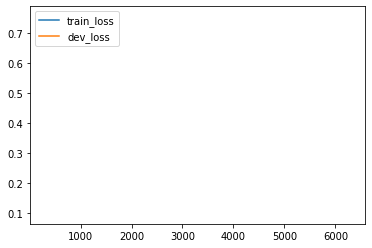

In [43]:
display(history.plot())

In [44]:
history

,train_loss,dev_loss
9.01,0.430252,NaN
9.00,NaN,0.406871
19.01,0.439899,NaN
19.00,NaN,0.423425
29.01,0.458890,NaN
29.00,NaN,0.373825
39.01,0.462353,NaN
39.00,NaN,0.378933
49.01,0.407788,NaN
49.00,NaN,0.404696


# fixed history code that got botched above. 
Testing original with history = history
adding all previous fc with (64, 32) and (32,16) all activated with ELU
0.9 dropout  << getting aggressive with dropout (looked like we overfitted on the model above. train_loss kept going down while val_loss hovered at .40)
0.0001 LR

In [45]:
import torch.nn as nn

class DFDCNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.9):
        super(DFDCNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.9)
        self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.elu = nn.ELU()
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.float()
        
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
#         out = self.batchnorm(out)
        out = self.fc1(out)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        out = self.elu(out)
        out = self.fc4(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [46]:
input_size = 512
output_size = 1
hidden_dim = 128
n_layers = 5

model = DFDCNet(input_size, output_size, hidden_dim, n_layers)
model.to(device)
train_criterion = nn.BCELoss()
val_criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
print(model)

DFDCNet(
  (lstm): LSTM(512, 128, num_layers=5, batch_first=True, dropout=0.9)
  (dropout): Dropout(p=0.9, inplace=False)
  (batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [47]:
# scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=500, verbose=True)


In [54]:
epochs = 10000
counter = 0
print_every = 1000
clip = .5
valid_loss_min = np.Inf
val_loss = torch.tensor(np.Inf)
model.train()
history = pd.DataFrame()
for i in range(epochs):
    h = model.init_hidden(train_batch_size)
    
    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = train_criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        
        if counter%print_every == 0:
            val_h = model.init_hidden(val_batch_size)
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = val_criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            history.loc[i + 1, 'train_loss'] = loss.data.cpu().numpy()
            history.loc[i + 1, 'dev_loss'] = val_loss.cpu().detach().numpy()
            
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './model_1face.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)
    scheduler.step(val_loss.item())


Epoch: 10/10000... Step: 1000... Loss: 0.400138... Val Loss: 0.395108
Validation loss decreased (inf --> 0.395108).  Saving model ...
Epoch: 20/10000... Step: 2000... Loss: 0.384487... Val Loss: 0.390183
Validation loss decreased (0.395108 --> 0.390183).  Saving model ...
Epoch: 30/10000... Step: 3000... Loss: 0.388891... Val Loss: 0.399166
Epoch: 40/10000... Step: 4000... Loss: 0.400144... Val Loss: 0.396218
Epoch: 50/10000... Step: 5000... Loss: 0.390128... Val Loss: 0.389486
Validation loss decreased (0.390183 --> 0.389486).  Saving model ...
Epoch: 60/10000... Step: 6000... Loss: 0.392917... Val Loss: 0.386507
Validation loss decreased (0.389486 --> 0.386507).  Saving model ...
Epoch: 90/10000... Step: 9000... Loss: 0.369805... Val Loss: 0.385383
Validation loss decreased (0.386507 --> 0.385383).  Saving model ...
Epoch: 100/10000... Step: 10000... Loss: 0.343799... Val Loss: 0.382633
Validation loss decreased (0.385383 --> 0.382633).  Saving model ...
Epoch: 110/10000... Step: 110

Epoch: 980/10000... Step: 98000... Loss: 0.238862... Val Loss: 0.334679
Validation loss decreased (0.334878 --> 0.334679).  Saving model ...


KeyboardInterrupt: 

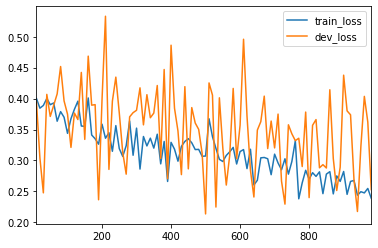

In [55]:
display(history.plot())

In [56]:
history

,train_loss,dev_loss
10,0.400138,0.394252
20,0.384487,0.304138
30,0.388891,0.247592
40,0.400144,0.406792
50,0.390128,0.371141
60,0.392917,0.389180
70,0.363402,0.407598
80,0.378886,0.451834
90,0.369805,0.396285
100,0.343799,0.374847
